In [1]:
DATASET_data = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root"
DATASET_mc_v6 = "nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.root"

In [2]:
import time
import os
import re

from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2
import hist
from hist import Hist
import mplhep as mplhep
from scipy.stats import binom
from scipy.stats import norm

In [3]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=False)
ar_data_sum = processor.getData(DATASET_data)

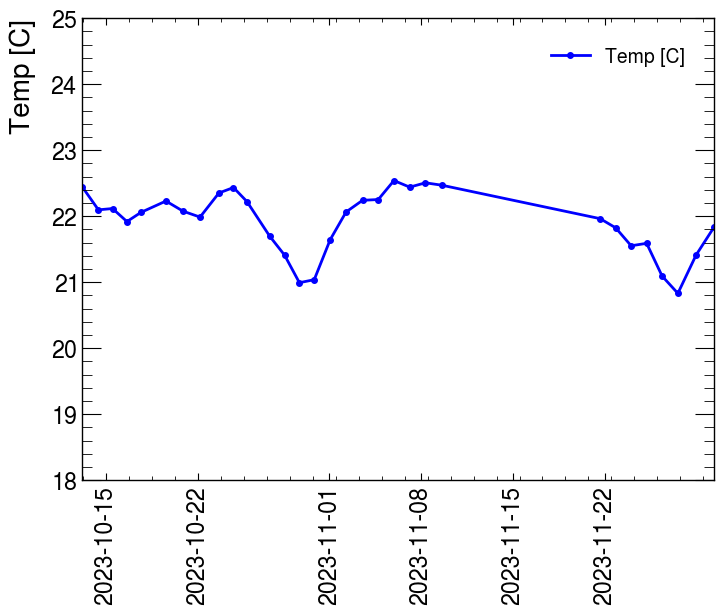

In [4]:
x=ar_data_sum["timestamp"].to_numpy()
y=ar_data_sum["meanTemperatures"][:,1,0].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, 'b.-', label='Temp [C]')
plt.xticks(rotation=90);
plt.ylim(18, 25)
plt.ylabel('Temp [C]')
plt.legend();

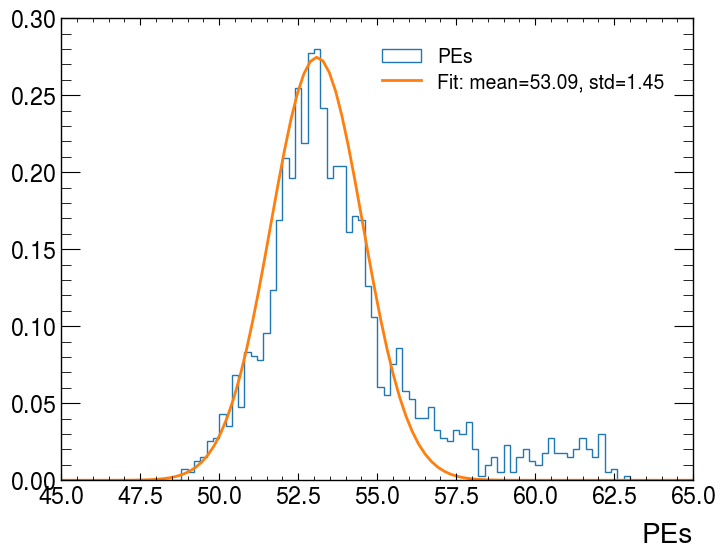

In [28]:
test_layers = np.arange(3, 4)
x = ar_data_sum["PEs"][:, test_layers, :].to_numpy()
x = np.ravel(x)
cut=(x>x.mean()-2*x.std()) & (x<x.mean()+x.std())
x_cut = x[cut]
# Fit a Gaussian distribution to the data
mean, std = norm.fit(x_cut)
# Plot the histogram
plt.hist(x, bins=100, range=(45, 65), density=True, label='PEs', histtype='step')
# Plot the fitted Gaussian curve
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_range, mean, std)
plt.plot(x_range, p, label='Fit: mean=%.2f, std=%.2f' % (mean, std))
plt.legend()
plt.xlabel('PEs')
plt.show()

In [10]:
%%time
processor = wideband.DataProcessor(usexroot=True, treename='CrvWidebandTest/WidebandTree')
ar6 = processor.getEffData("nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.root", data_type=6)
processor = wideband.DataProcessor(usexroot=True, treename='run')
ar_data = processor.getEffData("rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root", data_type=-1)

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v6/root/df/f3/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.001006_00000000.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v6/root/4c/17/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.001006_00000038.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v6/root/6a/65/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.001006_00000108.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v6/root/20/7b/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v6.001006_00000151.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_00

In [11]:
ar_skim = ak.concatenate([ar6, ar_data])

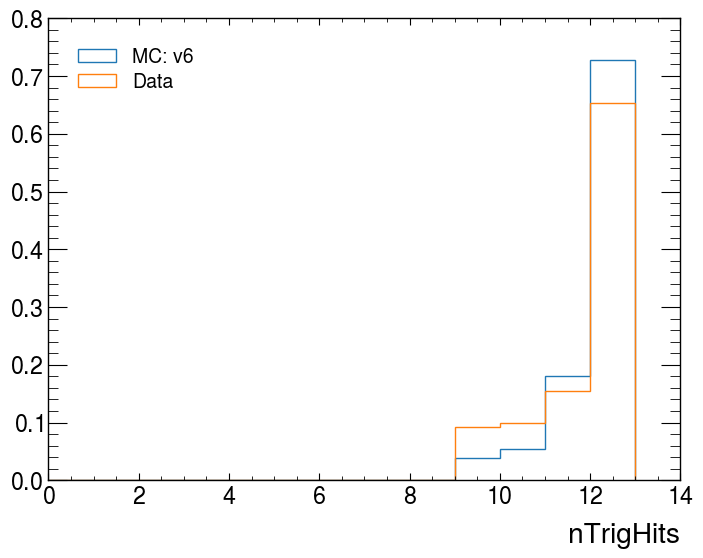

In [12]:
plt.hist(ar_skim[ar_skim['dataType']==6]['nTrigHits'], bins=13, range=(0, 13), histtype='step', label='MC: v6', density=True);
plt.hist(ar_skim[ar_skim['dataType']==-1]['nTrigHits'], bins=13, range=(0, 13), histtype='step', label='Data', density=True);
plt.xlabel('nTrigHits')
plt.legend();

In [13]:
# Cuts
chi2NDF_lower_limit = 0
chi2NDF_upper_limit = 30

intercept_lower_limit = -700
intercept_upper_limit = -200

trackPoints_limit = 40
trackPEs_limit = 3000
nTrigHits_limit = 12

# Define the cut conditions
condition_chi2 = (ar_skim["trackChi2NDF"] > chi2NDF_lower_limit) & (ar_skim["trackChi2NDF"] < chi2NDF_upper_limit)
condition_intercept = (ar_skim["trackIntercept"] > intercept_lower_limit) & (ar_skim["trackIntercept"] < intercept_upper_limit)
condition_trackPEs = ar_skim["trackPEs"] < trackPEs_limit
condition_nTrigHits = ar_skim["nTrigHits"] >= nTrigHits_limit
condition_trackPoints = ar_skim["trackPoints"] < trackPoints_limit

# Cut categories
cut_categories = [condition_chi2, 
                  condition_chi2 & condition_intercept, 
                  condition_chi2 & condition_intercept & condition_trackPEs, 
                  condition_chi2 & condition_intercept & condition_trackPEs & condition_nTrigHits, 
                  condition_chi2 & condition_intercept & condition_trackPEs & condition_nTrigHits & condition_trackPoints]

In [14]:
# Create histograms
axis1 = hist.axis.IntCategory(label='NHits', name='nhits', categories=[1, 2, 3, 4])
axis2 = hist.axis.StrCategory(label='Cuts', name='cut', categories=["trackChi2", "intercept", "trackPEs", "nTrigHits", "all"])
axis3 = hist.axis.IntCategory(label='Data type', name='dtype', categories=[-1, 1, 2, 3, 4, 5, 6])
axis4 = hist.axis.IntCategory(label='NLayers', name='layer', categories=[1, 2, 3, 4])

h_nTrigHits = Hist(hist.axis.Regular(6, 8, 14, name="nTrigHits"), axis1, axis2, axis3)
h_PEsTestLayers = Hist(hist.new.Reg(100, 0, 200, name="PEsTestLayers"), axis1, axis2, axis3)
h_trackChi2NDF = Hist(hist.new.Reg(100, 0, 100, name="trackChi2NDF"), axis1, axis2, axis3)
h_trackPEs = Hist(hist.new.Reg(100, 1000, 5000, name="trackPEs"), axis1, axis2, axis3)
h_trackPoints = Hist(hist.new.Reg(80, 0, 80, name="trackPoints"), axis1, axis2, axis3)
h_trackIntercept = Hist(hist.new.Reg(80, -1000, 100, name="trackIntercept"), axis1, axis2, axis3)
h_trackSlope = Hist(hist.new.Reg(80, -1, 1, name="trackSlope"), axis1, axis2, axis3)

h_trackPEsHit = Hist(hist.new.Reg(100, 0, 500, name="trackPEsHit"), axis1, axis2, axis3)

h_PEsLayer = Hist(hist.new.Reg(100, 0, 500, name="PEsLayer", flow=True), axis1, axis2, axis3, axis4)
h_PEsLayerSort = Hist(hist.new.Reg(100, 0, 500, name="PEsLayerSort", flow=True), axis1, axis2, axis3, axis4)

histogram_list = [h_nTrigHits, h_PEsTestLayers, h_trackChi2NDF, 
                  h_trackPEs, h_trackPoints, h_trackIntercept, h_trackSlope]

# Iterate over nhits values and fill the histograms
for data_type in axis3:
    dtype_condition = (ar_skim["dataType"] == data_type)
    for nhits in axis1:
        hits_condition = ar_skim['nTestHits'] <= nhits
        for idx, cut in enumerate(axis2):

            cut_condition = cut_categories[idx] & hits_condition & dtype_condition

            for histogram in histogram_list:
                var_name = histogram.axes[0].label
                if(var_name == "PEsTestLayers"):
                    arr_fill = ak.flatten(ar_skim[cut_condition][var_name])
                else:
                    arr_fill = ar_skim[cut_condition][var_name]
                histogram.fill(arr_fill, nhits=nhits, cut=cut, dtype=data_type)

            h_trackPEsHit.fill(ar_skim[cut_condition]['trackPEs']/ar_skim[cut_condition]['trackPoints'], nhits=nhits, cut=cut, dtype=data_type)

            for layer in axis4:
                h_PEsLayer.fill(ar_skim[cut_condition]['PEsTestLayers'][:,layer-1], nhits=nhits, cut=cut, dtype=data_type, layer=layer)
                h_PEsLayerSort.fill(ak.sort(ar_skim[cut_condition]['PEsTestLayers'], axis=1)[:,layer-1], nhits=nhits, cut=cut, dtype=data_type, layer=layer)

histogram_list.extend([h_trackPEsHit, h_PEsLayerSort, h_PEsLayer])

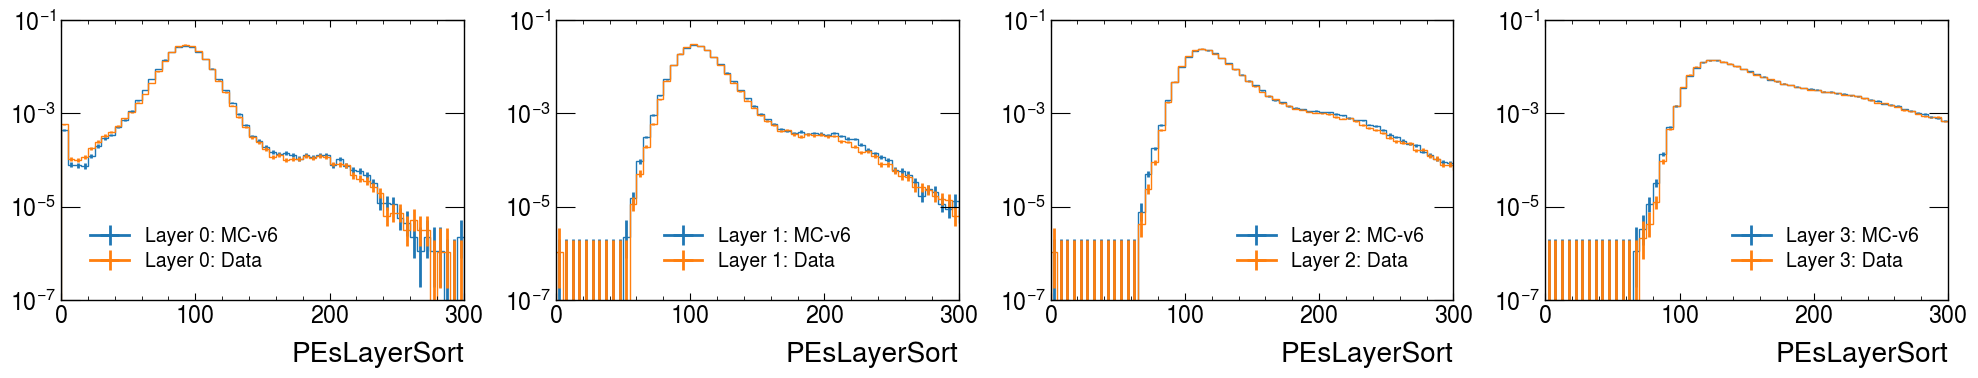

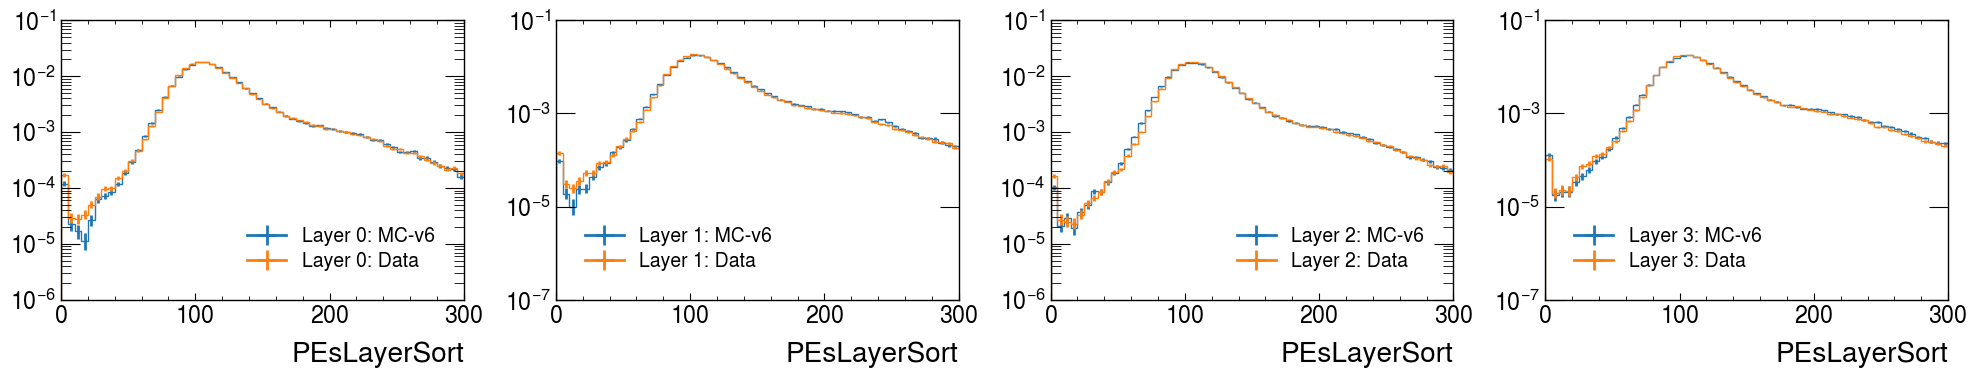

In [15]:
def plot_layer(ax, h_PEsLayer, layer):
    for source, label in [("MC-v6", 6), ("Data", 0)]:
        h_PEsLayer[:, 3, "all", label, layer].plot(flow="sum", label=f'Layer {layer}: {source}', density=True, ax=ax)
        ax.set_xlim(0, 300)
        ax.legend()
        ax.set_yscale('log')
    ax.set_xlabel("PEsLayerSort")

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for layer, ax in enumerate(axes):
    plot_layer(ax, h_PEsLayerSort, layer)
plt.tight_layout()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for layer, ax in enumerate(axes):
    plot_layer(ax, h_PEsLayer, layer)
plt.tight_layout()

In [16]:
def get_extrapolated_efficiency(cut, data_type, nfold):
    h = h_PEsLayer[:, 3, cut, data_type, :]
    # Normalize histogram to unity
    normalized_hist = np.mean(h, axis=1) / np.mean(h, axis=1).sum()
    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = binom.cdf(3-nfold, 4, 1 - cdf)
    return cdf

In [17]:
def plot_efficiency(nfold, data_type):

    h = h_PEsLayerSort[:, 3, "intercept", data_type, nfold]
    # Normalize histogram to unity
    normalized_hist = h.values() / h.sum(flow=True)

    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = np.clip(cdf, 1e-10, 1 - 1e-10)

    # Calculate the error bars for the CDF
    error_cdf = np.sqrt(cdf * (1 - cdf) / h.sum(flow=True))

    # Plot the normalized histogram and CDF with error bars on the same axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the second lowest PEs
    mplhep.histplot(h, ax=ax1, label='PEs layer: sorted', flow="sum")
    # Create a second y-axis
    ax2 = ax1.twinx()
    ax2.fill_between(h.axes[0].centers, cdf - error_cdf, cdf + error_cdf, color='red', alpha=0.2, label='Meas. %d/4 inefficiency'%(4-nfold))
    ax2.plot(h.axes[0].centers, cdf, 'r-', linewidth=0.5)

    cdf_est = get_extrapolated_efficiency("all", data_type, nfold)
    ax2.plot(h.axes[0].centers, cdf_est, 'b-', alpha=0.7, label='Extrap. %d/4 inefficiency'%(4-nfold))

    # Set labels for both y-axes
    ax1.set_ylabel('Counts', color='blue')
    ax2.set_ylabel('Cumulative Probability', color='red')
    
    ax2.axhline(y=1E-4, color='red', linestyle='--', label='CRV requirement', linewidth=1)

    plt.legend(loc='upper left')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    plt.xlim(0, 200);
    plt.ylim(1E-6, 10);

<Figure size 800x600 with 0 Axes>

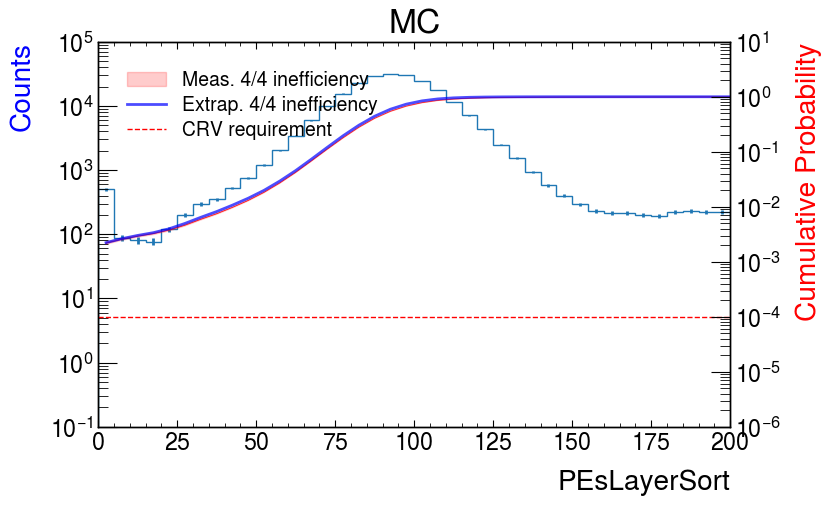

<Figure size 800x600 with 0 Axes>

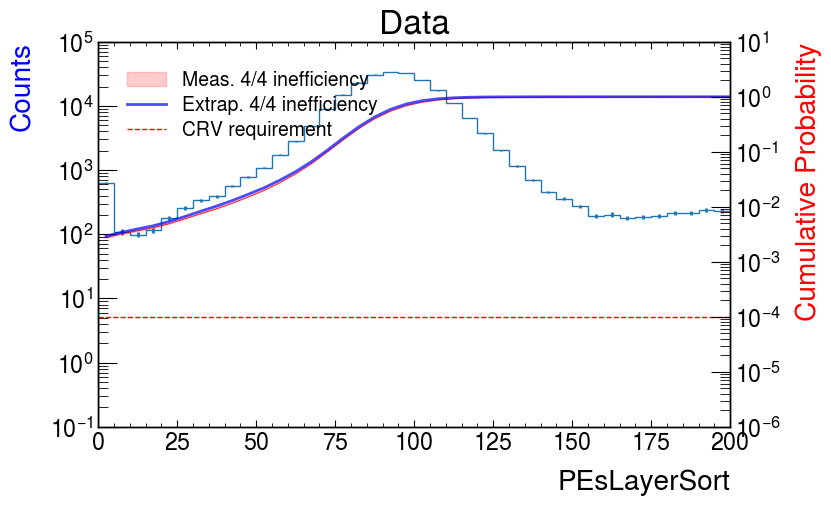

<Figure size 800x600 with 0 Axes>

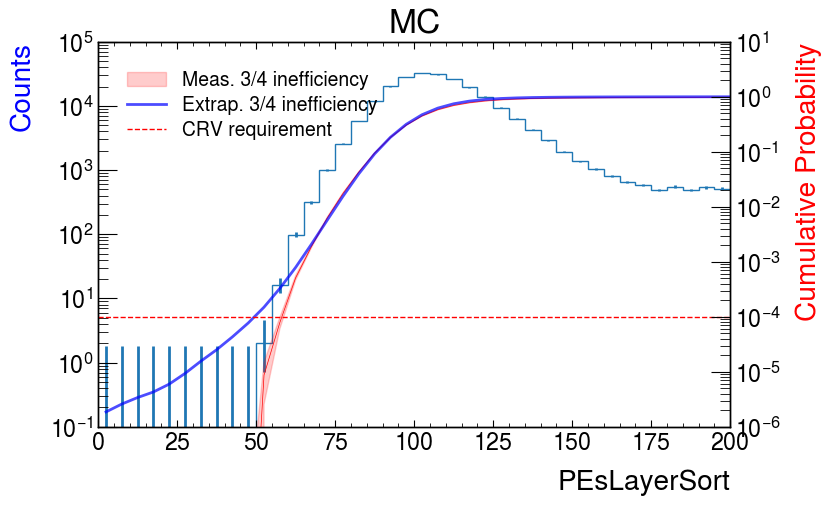

<Figure size 800x600 with 0 Axes>

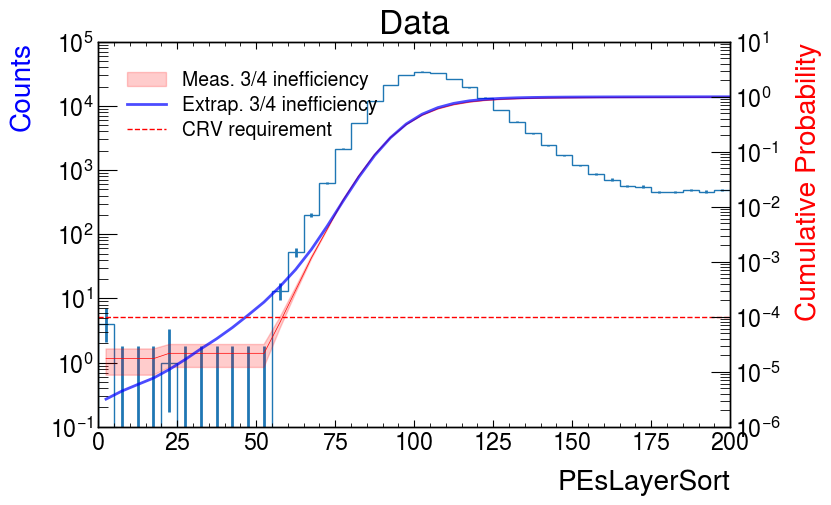

<Figure size 800x600 with 0 Axes>

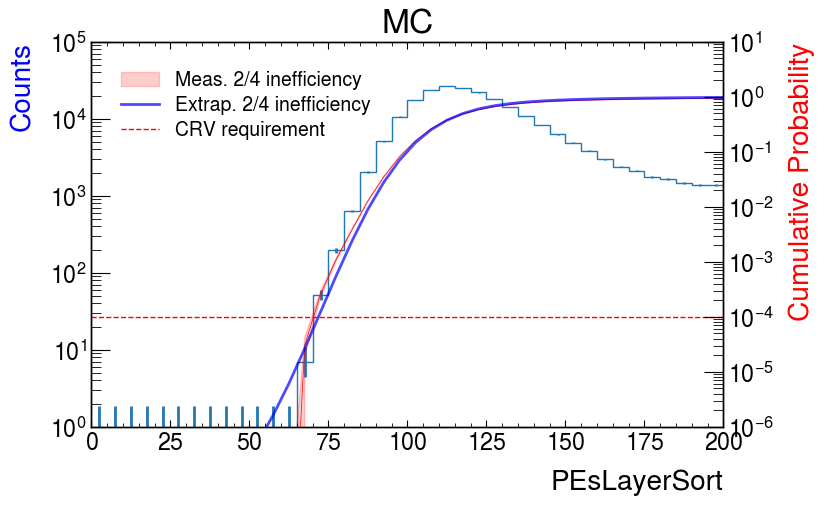

<Figure size 800x600 with 0 Axes>

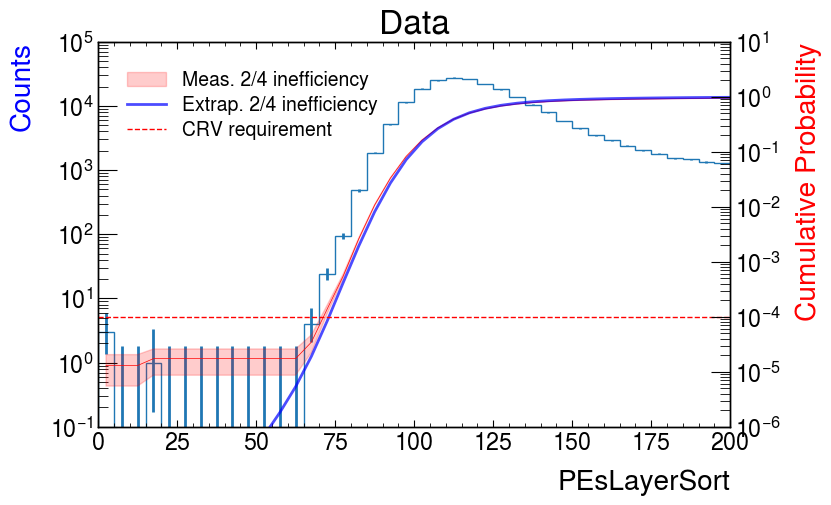

<Figure size 800x600 with 0 Axes>

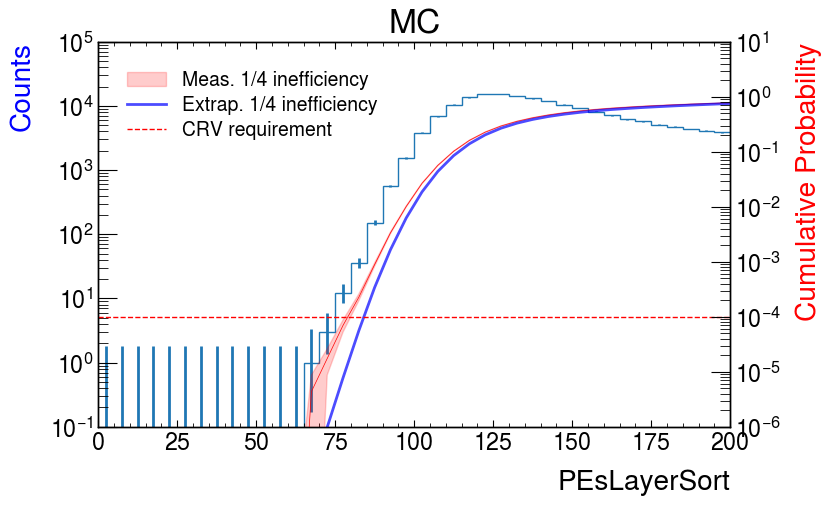

<Figure size 800x600 with 0 Axes>

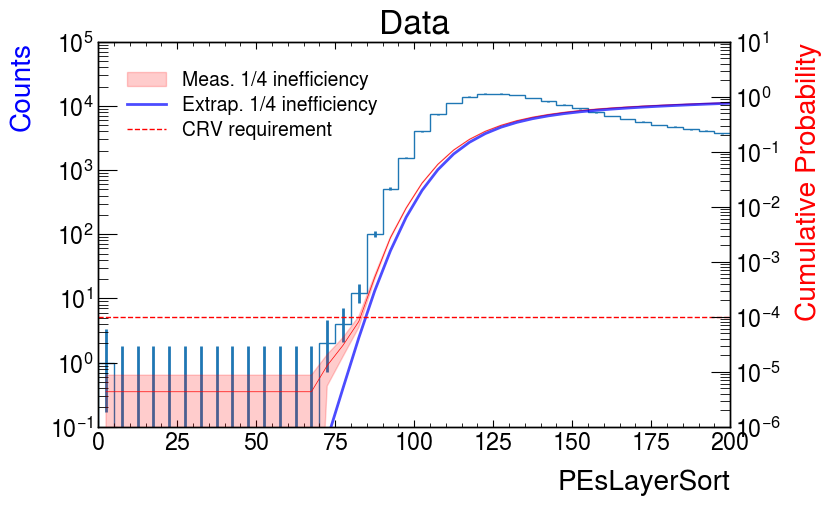

In [18]:
for nfold in range(0,4):
    plt.figure()
    plot_efficiency(nfold, 6);
    plt.title("MC")
    
    plt.figure()
    plot_efficiency(nfold, 0);
    plt.title("Data")

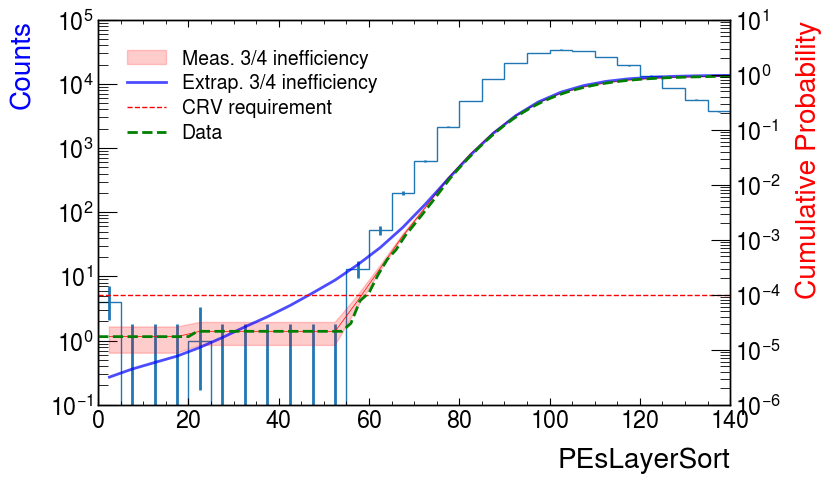

In [19]:
#Just a cross-check

# Plot MC
plot_efficiency(1, False);

#Plot Data
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[1] & (ar_skim["dataType"]==-1)]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=1000, range=(0, 2000))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative, "--g", label='Data')
plt.legend()
plt.yscale('log');
plt.xlim(0,140);

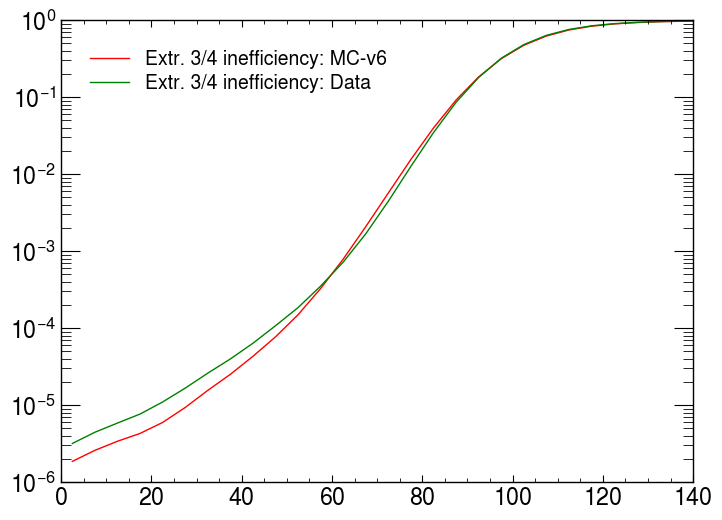

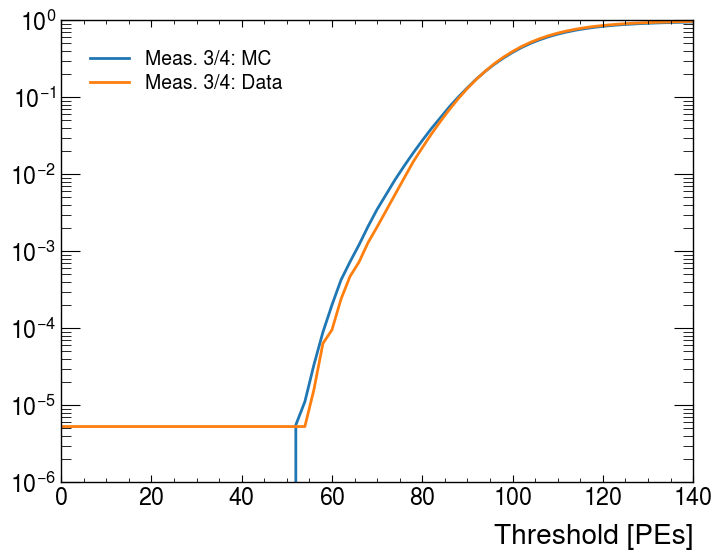

In [20]:
#Plot extrapolated 3/4 measurements
h = h_PEsLayerSort[:, 3, "all", 6, 1]
cdf_est = get_extrapolated_efficiency("all", 6, 1)
plt.plot(h.axes[0].centers, cdf_est, 'r-', label='Extr. 3/4 inefficiency: MC-v6', linewidth=1)
cdf_est = get_extrapolated_efficiency("all", 0, 1)
plt.plot(h.axes[0].centers, cdf_est, 'g-', label='Extr. 3/4 inefficiency: Data', linewidth=1)
plt.yscale('log');
plt.xlim(0,140);
plt.ylim(1e-6,1);
plt.legend()

#Plot direct 3/4 measurements
plt.figure()
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[4] & (ar_skim["dataType"]==6) ]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=1000, range=(0, 2000))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative,  label='Meas. 3/4: MC')
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[4] & (ar_skim["dataType"]==-1)]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=100, range=(0, 200))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative, label='Meas. 3/4: Data')
plt.legend()
plt.ylim(1e-6,1);
plt.yscale('log');
plt.xlim(0,140);
plt.xlabel('Threshold [PEs]');

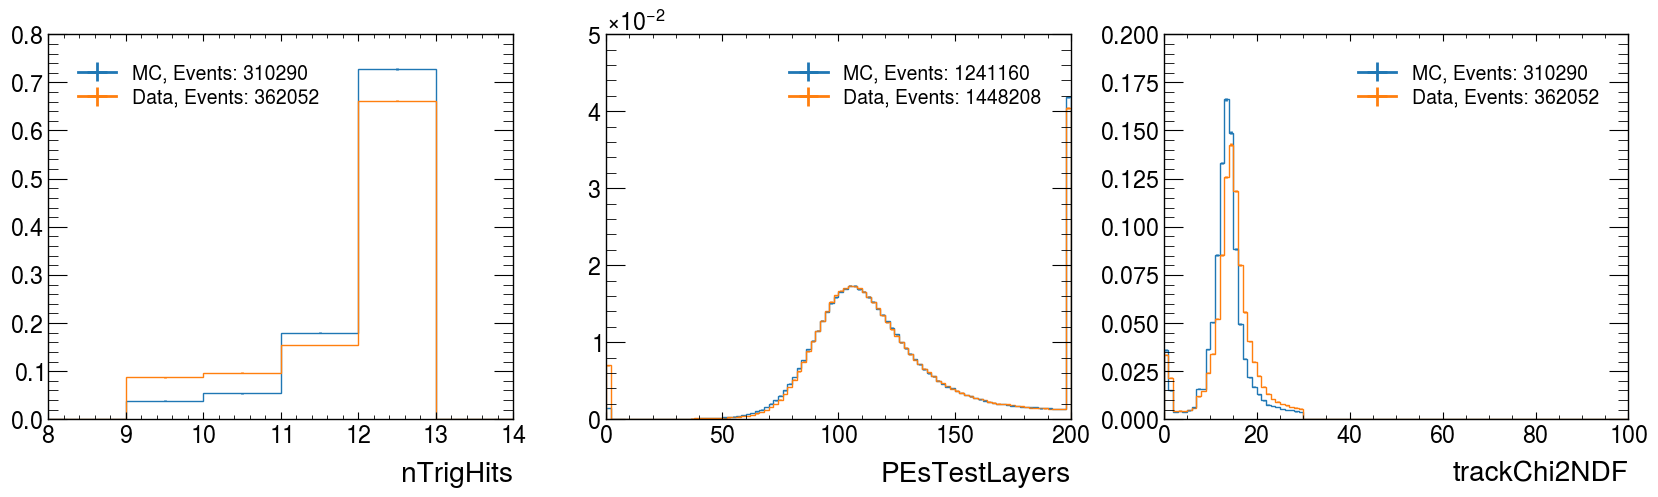

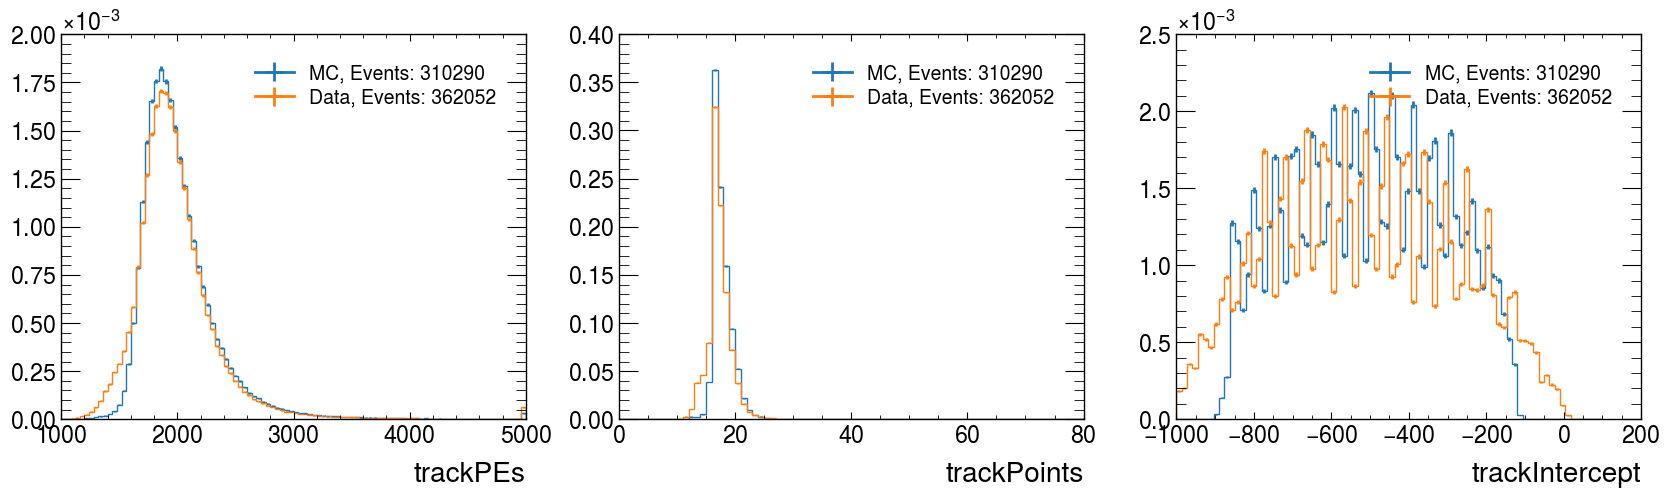

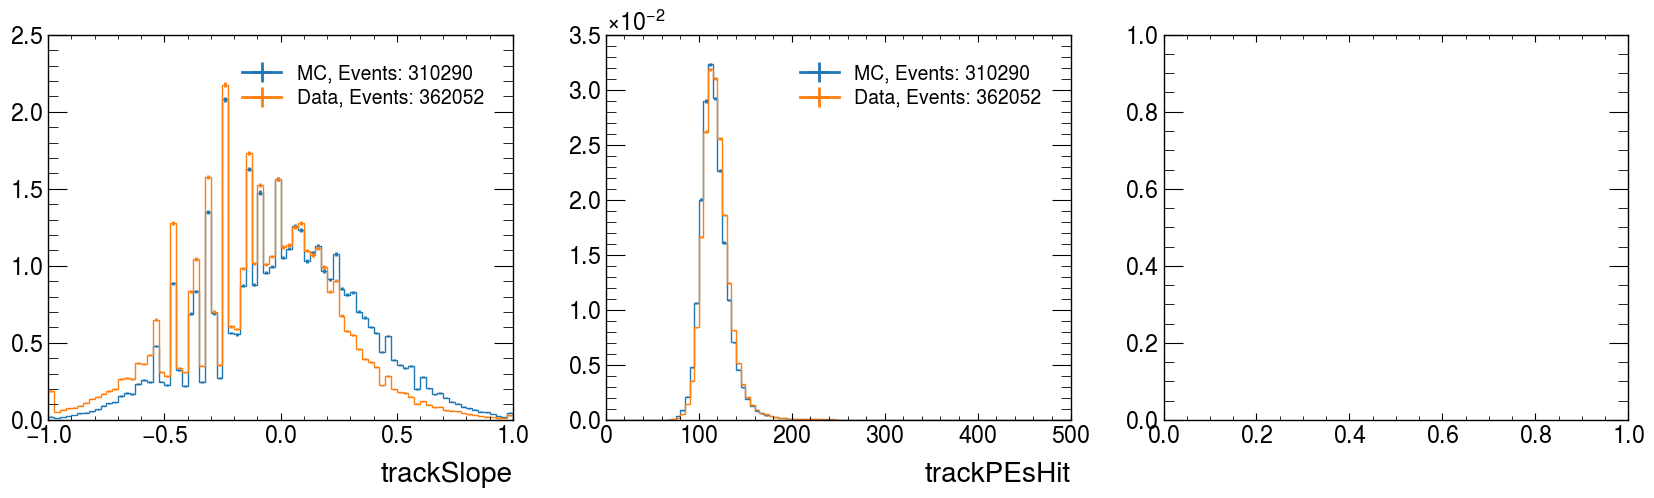

In [21]:
for idx, histogram in enumerate(histogram_list[:-2]):
    ncols = 3
    ax_id = idx%ncols
    if ax_id == 0:
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 5))

    h = histogram[:, 3, "trackChi2", 6]
    mplhep.histplot(h, ax=axes[ax_id], label="MC, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")

    h = histogram[:, 3, "trackChi2", 0]
    mplhep.histplot(h, ax=axes[ax_id], label="Data, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")
    
    axes[ax_id].set_xlabel(histogram.axes[0].label)
    axes[ax_id].legend()

Distributions before any cuts 

In [22]:
#Apply cuts
ar_skim['nTestHits'] = ak.sum(ar_skim['PEsTestLayers'] > 10, axis=-1)
ar_3l = ar_skim[cut_categories[4] & (ar_skim['nTestHits']<3) & (ar_skim['dataType']==-1)]  # less than 3 hits
ar_4e = ar_skim[cut_categories[4] & (ar_skim['nTestHits']==4) & (ar_skim['dataType']==6)] # equal to 4 hits

In [23]:
ar_skim_fields = ar_skim.fields.copy()
ar_skim_fields.remove('PEsTestLayers')

In [24]:
pd.set_option('display.max_rows', None)
ak.to_dataframe(ar_3l[ar_skim_fields])

,spillNumber,eventNumber,runNumber,subrunNumber,trackPEs,trackPoints,trackChi2,trackIntercept,trackSlope,nTrigHits,dataType,trackChi2NDF,nTestHits
entry,,,,,,,,,,,,,
0,1131,275,1738,2,1564.383545,19,279.417267,-426.385559,-0.037259,12,-1,16.43631,1


In [25]:
eff = len(ar_3l)/len(ar_4e)
print("Efficiency at 10 PE: %.2e"%eff)

Efficiency at 10 PE: 5.57e-06
